In [40]:
import chart
import csv
import urllib.request
import json
import matplotlib.pyplot as plt

# First analysis

We wanted to make an analysis on the number of citations for the different DOI categories. We have classified the DOI resources into five classes: Journal, Book, Proceedings, Dataset, Other. The citations count are taken from two different sources:

1. COCI: those are open citations made available and retrieved from the COCI dataset. In this case the citations are counted through the analysis of all the DOIs (items in the dataset) that have an open reference-list.
2. Crossref: the number of citations given by Crossref. In this case the total count includes also citations made from closed resources which do not publish there reference list: closed citations. This value is presented as an attribute for each item in the COCI dataset.
 
**Note:** All the information are included/calculated from the last COCI dataset dump available at the OpenCitations website: http://opencitations.net/download#coci

These values are compared in the chart bellow.

In [7]:
#Prepare the data needed as input to build the chart
DOI_TYPES_CSV = "../data/croci_types.csv"
dict_types = {}
with open(DOI_TYPES_CSV,'r') as cocicsv:
    cocicsv_reader = csv.DictReader(cocicsv)
    for row in cocicsv_reader:
        dict_types[row['type']] = {}
        dict_types[row['type']]['label'] = row['label']
        dict_types[row['type']]['coci_open'] = int(row['coci_open'])
        dict_types[row['type']]['crossref_close'] = int(row['crossref_close'])
        dict_types[row['type']]['total'] = int(row['crossref_close']) + int(row['coci_open']) 

types_data = ['journal','book','proceedings','dataset','other']

x_data = []
for k in types_data:
    x_data.append(dict_types[k]['label'])

o_in_coci = []
for k in types_data:
    o_in_coci.append(dict_types[k]['coci_open'])
    
c_in_crossref = []
for k in types_data:
    c_in_crossref.append(dict_types[k]['crossref_close'])
    
data_plot = {
     'Open in COCI': {'x': x_data, 'y': o_in_coci },
     'Close in Crossref': {'x': x_data, 'y': c_in_crossref }
}

{'Journal': [425772007, 322345327], 'Book': [12658874, 2674915], 'Proceedings': [10196710, 661250], 'Dataset': [33357, 2025], 'Other': [403626, 111019]}


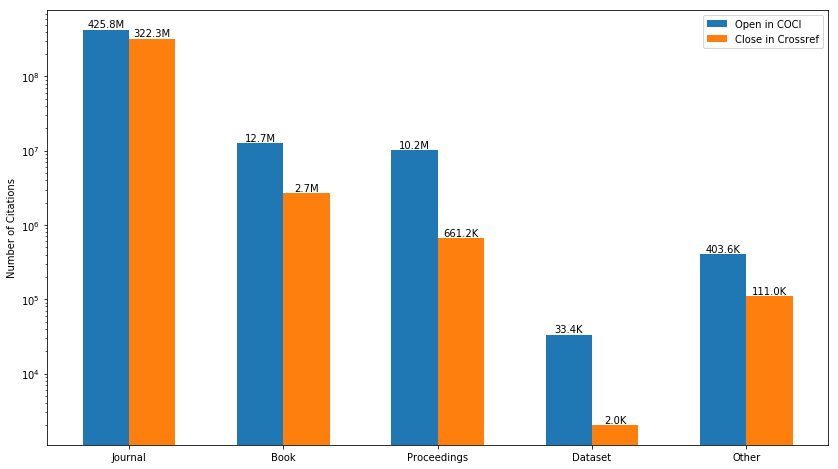

In [11]:
#Call the chart builder and draw it
chart.plotBars(data_plot,opt = {'ylabel': 'Number of Citations', 'bar_val':True,'bar_coi':1000000,'bar_suf':'M','bar_pre':''}, sortit= False, logit= True).show()

# Second analysis
Taken in consideration the same previous sources as a citation count value, we wanted to classify the number of citations for each different publisher. To count the citations we took in consideration the previous sources described in the first analysis: COCI and Crossref. Our processing workflow is described as follow:
1.  Firstly, we took as input the COCI dataset and collected all the DOI prefixes we have: the DOI prefix indicates the publisher. 
2. We used the Crossref API to get the publisher name of each different DOI prefix. e.g: http://api.crossref.org/prefixes/10.3129 
3. For each different publisher we counted the number of citations ‘Open in COCI’ and ‘Close in Crossref’ for all its related DOIs

**Note:** All the information are included/calculated from the last COCI dataset dump available at the OpenCitations website: http://opencitations.net/download#coci


In [ ]:
#BUILD INDEX
index_processed = {}
with open('../data/publishers_cits.csv','r') as cocicsv:
    cocicsv_reader = csv.DictReader(cocicsv)
    for row in cocicsv_reader:
        index_processed[row['doi_prefix']] = True
        
        
#PROCESS the Stream
extended_publishers = []
STREAM_BUF = 1000
#read all the DOI prefixes we have and ask Crossref for the publisher name
with open("../data/publishers_stats.csv",'r') as cocicsv:
    cocicsv_reader = csv.DictReader(cocicsv)
    for row in cocicsv_reader:
        if(row['doi_pref'] not in index_processed):
            entry_row = row
            if row['name'] == 'nn':
                api_call = 'http://api.crossref.org/prefixes/'+row['doi_pref']
                try:
                    contents = urllib.request.urlopen(api_call).read()
                    contents = json.loads(contents)
                    entry_row['name'] = contents['message']['name']
                    entry_row['crossref_member'] = contents['message']['member']
                    #print(api_call, "::",contents['message']['name'])
                except Exception as e:
                    continue
            else:
                row['name'] = re.search('\[\[(.*)\]\]', row['name'] ,re.U).group(1)

            extended_publishers.append(entry_row)

            #publisher,coci_open_cit,crossref_close_cit,total_cit
            file_res = open('../data/publishers_cits.csv','a')  
            file_res.write('"'+entry_row['name']+'","'
                           + entry_row['doi_pref'] +'","'
                           + entry_row['coci_open'] +'","'
                           + entry_row['crossref_close'] +'","'
                           + str(int(entry_row['coci_open']) + int(entry_row['crossref_close']))
                           +'"\n')  
            file_res.close()

            STREAM_BUF -= 1
            if STREAM_BUF == 0:
                break

<img src="../data/20publishers_cits.png" width="950" alt="accessibility text">

# Third analysis
Here we wanted to generate a .csv file containing the number of: open,limited, and closed, DOI resources having a reference list.  
To retrieve such data we used the Crossref API. For instance, the following call retrieves the number of 'closed' items having a reference list and 'Elsevir' as there publisher.   
http://api.crossref.org/members/78/works?filter=has-references:true,reference-visibility:closed

First of all we need to retrieve the Crossref ‘member’ ID for each DOI-Prefix of a given publisher. Then we will call the previous API call with the corresponding ‘member’ ID and for the three types of reference visibility: open, limited, closed.

In [24]:
#Get the Crossref 'member' ID value for each DOI prefix to each different publisher
PUB_PREFIX_CSV = "../data/20publishers_prefixes.csv"
dict_prefix = {}
with open(PUB_PREFIX_CSV,'r') as cocicsv:
    cocicsv_reader = csv.DictReader(cocicsv)
    for row in cocicsv_reader:
        all_prefixes = row['doi_prefix'].split(',') 
        dict_prefix[row['publisher']] = {}
        dict_prefix[row['publisher']]['doi_prefix'] = all_prefixes
        
        all_members = []
        for doi_p in all_prefixes:
            api_call = 'http://api.crossref.org/prefixes/'+str(doi_p)
            try:
                contents = urllib.request.urlopen(api_call).read()
                contents = json.loads(contents)
                all_members.append(str(contents['message']['member'].split('/')[-1]))
            except Exception as e:
                all_members.append('nn')
        
        dict_prefix[row['publisher']]['member'] = all_members

In [30]:
#for each different 'member' ID check the number of: open, limited, and closed, resources. 
for publisher_k in dict_prefix:
    all_members = dict_prefix[publisher_k]['member']
    dois_obj = {'open': 0,'limited': 0,'closed': 0}
    mem_dois_index = {}
    for mem in all_members:
        if mem not in mem_dois_index:
            api_call = "http://api.crossref.org/members/"+mem+"/works?filter=has-references:true,reference-visibility:"
            for cat in dois_obj:
                try:
                    contents = urllib.request.urlopen(api_call+cat).read()
                    contents = json.loads(contents)
                    dois_obj[cat] += contents['message']['total-results']
                except Exception as e:
                    continue
            mem_dois_index[mem] = True
    dict_prefix[publisher_k]['value'] = dois_obj
    

In [37]:
#Generate the .CSV file 
file_res = open('../data/publishers_ref_dois_crossref.csv','w')  
#file_res.write('publisher,doi_prefix,member,open,limited,closed\n')  
file_res.write('publisher,open,limited,closed\n')
file_res.close()

for pub in dict_prefix:
    file_res = open('../data/publishers_ref_dois_crossref.csv','a')  
    entry_row = dict_prefix[pub]
    
    all_dois_prefix = ""
    for d in entry_row['doi_prefix']:
        all_dois_prefix = all_dois_prefix + d + ","
    all_dois_prefix = all_dois_prefix[:-1]
    
    all_mems = ""
    for d in entry_row['member']:
        all_mems = all_mems + d + ","
    all_mems = all_mems[:-1]
    
    file_res.write('"'+pub+'","'
                    #+ all_dois_prefix +'","'
                    #+ all_mems +'","'
                    + str(entry_row['value']['open']) +'","'
                    + str(entry_row['value']['limited']) +'","'
                    + str(entry_row['value']['closed'])+'"\n')  
    file_res.close()

<img src="../data/20publishers_cr.png" width="900" alt="accessibility text">